### Data Exploration

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('reviews.csv')
df.shape

(17660, 13)

In [19]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17660 non-null  object
 1   userName              17660 non-null  object
 2   userImage             17660 non-null  object
 3   content               17659 non-null  object
 4   score                 17660 non-null  int64 
 5   thumbsUpCount         17660 non-null  int64 
 6   reviewCreatedVersion  15137 non-null  object
 7   at                    17660 non-null  object
 8   replyContent          9792 non-null   object
 9   repliedAt             9792 non-null   object
 10  appVersion            15137 non-null  object
 11  sortOrder             17660 non-null  object
 12  appId                 17660 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.8+ MB


Text(0.5, 0, 'review score')

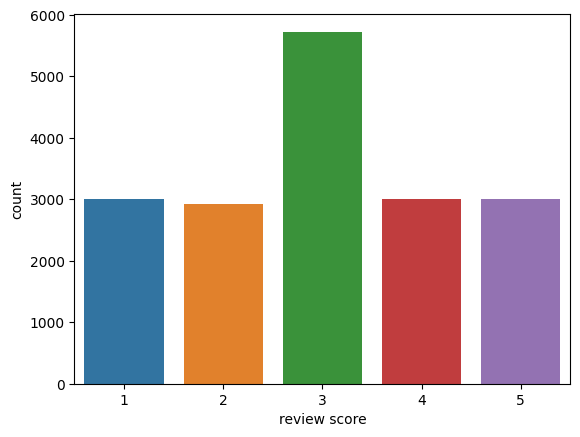

In [20]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
sns.countplot(x='score', data=df, hue='score', palette=colors, legend=False)
plt.xlabel('review score')

In [21]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

C:\Users\hp\AppData\Local\Temp\ipykernel_25152\1125166575.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

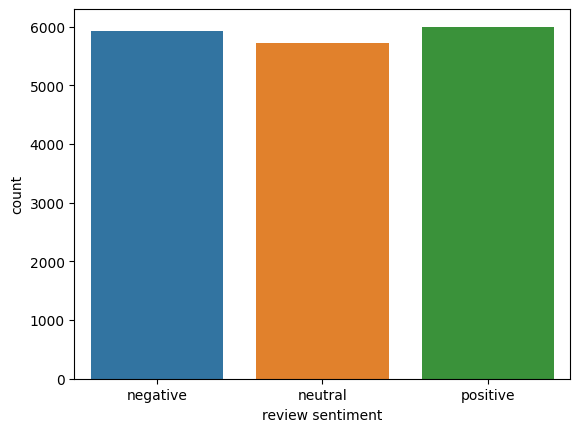

In [22]:
class_names = ['negative', 'neutral', 'positive']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax = sns.countplot(x='sentiment', data=df, hue='sentiment', palette=colors, legend=False)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

### Data Preprocessing